# Анализ AI-контента на сайтах университетов Казахстана

In [1]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---- Настройки пользователя ----
# Можно явно указать путь, если автопоиск не найдёт:
MANUAL_JSON_PATH = None  # например: r"C:\Users\cheen\Desktop\book_parse\results_batch_....json"

# Папки, где ищем данные (можешь добавить свои)
SEARCH_DIRS = [
    Path("."),           # рядом с ноутбуком
    Path("./data"),      # папка data рядом с ноутбуком
    Path(".."),          # уровнем выше
    Path("../data"),     # data уровнем выше
]

def find_latest_results_json():
    if MANUAL_JSON_PATH:
        p = Path(MANUAL_JSON_PATH)
        if p.exists():
            return p
        raise FileNotFoundError(f"MANUAL_JSON_PATH задан, но файл не найден: {p}")

    candidates = []
    for d in SEARCH_DIRS:
        if d.exists():
            candidates += list(d.glob("results_batch_*.json"))
    if not candidates:
        raise FileNotFoundError(
            "Не найден файл results_batch_*.json. "
            "Положи JSON рядом с ноутбуком или в папку data/ (или задай MANUAL_JSON_PATH)."
        )
    # берём самый новый по времени изменения
    candidates.sort(key=lambda x: x.stat().st_mtime, reverse=True)
    return candidates[0]

DATA_PATH = find_latest_results_json()
DATA_PATH


WindowsPath('results_batch_serper_collection_20260116_080917_258ed4c6_20260120_075330.json')

## 1. Загрузка данных в DataFrame

In [2]:

def load_constructor_export(path: Path) -> pd.DataFrame:
    raw = json.loads(path.read_text(encoding="utf-8", errors="ignore"))

    # ожидаем структуру: {"batch_id":..., "exported_at":..., "data": {"parsed_results":[...]}}
    if isinstance(raw, dict) and "data" in raw and isinstance(raw["data"], dict):
        if "parsed_results" in raw["data"]:
            records = raw["data"]["parsed_results"]
        elif "results" in raw["data"]:
            records = raw["data"]["results"]
        else:
            # пробуем найти первый список в data
            lists = [v for v in raw["data"].values() if isinstance(v, list)]
            if not lists:
                raise ValueError("Не нашёл список записей внутри raw['data']. Проверь структуру JSON.")
            records = lists[0]
    else:
        raise ValueError("JSON имеет неожиданную структуру верхнего уровня (ожидался dict с ключом 'data').")

    if not isinstance(records, list):
        raise ValueError("Ожидался список записей parsed_results.")

    return pd.DataFrame(records)

df = load_constructor_export(DATA_PATH)
len(df), df.columns.tolist()[:15]


(2148,
 ['result_id',
  'link_id',
  'final_url',
  'title',
  'content_text',
  'keywords_extracted',
  'word_count',
  'language_detected',
  'http_status_code',
  'batch_id',
  'created_at',
  'updated_at',
  'content_quality_score',
  'has_useful_content',
  'is_pdf'])

## 2. Предобработка: текст, слова, домены, PDF, язык, тип контента, год публикации

In [3]:

# --- базовые поля ---
df["content_text"] = df.get("content_text", "").fillna("").astype(str)
df["title"] = df.get("title", "").fillna("").astype(str)
df["final_url"] = df.get("final_url", "").fillna("").astype(str)
df["keywords_extracted"] = df.get("keywords_extracted", "").fillna("").astype(str)

# текст и объём
df["has_text"] = df["content_text"].str.strip().str.len() > 0
df["word_count"] = df["content_text"].apply(lambda x: len(str(x).split()))
df["good_100"] = df["word_count"] >= 100
df["good_300"] = df["word_count"] >= 300

# pdf
if "is_pdf" not in df.columns:
    df["is_pdf"] = df["final_url"].str.lower().str.contains(r"\.pdf(\?|$)", regex=True)
else:
    df["is_pdf"] = df["is_pdf"].fillna(False).astype(bool)

# домен (если нет или пустой)
if "domain_filter" not in df.columns or df["domain_filter"].isna().all():
    df["domain_filter"] = df["final_url"].str.extract(r"https?://([^/]+)")[0].str.lower()
else:
    df["domain_filter"] = df["domain_filter"].fillna("").astype(str).str.lower()
    # если встречается пусто — попробуем заполнить из URL
    mask_empty = df["domain_filter"].str.strip().eq("")
    df.loc[mask_empty, "domain_filter"] = df.loc[mask_empty, "final_url"].str.extract(r"https?://([^/]+)")[0].str.lower()

# язык (как есть)
df["language_detected"] = df.get("language_detected", "unknown").fillna("unknown").astype(str).str.lower()

# --- классификация типа контента (RU/EN + универсальные паттерны) ---
df["text_for_type"] = (
    df["final_url"].str.lower() + " " +
    df["title"].str.lower() + " " +
    df["keywords_extracted"].str.lower() + " " +
    df["content_text"].str.lower().str.slice(0, 1500)
)

PATTERNS = {
    "news": r"\b(news|новост|пресс|press|анонс|объявлен|сообщени|медиа|media|event|мероприяти|конкурс|встреча|семинар|форум)\b|/news|/novosti|/press|/media",
    "education": r"\b(program|programme|curriculum|syllabus|course|admission|apply|enroll|student|бакалавр|магистр|доктор|докторант|абитуриент|поступлен|образоват|учебн|дисциплин|кафедр|факультет|специальност|траектори|курсы|программа)\b|/admission|/abiturient|/education|/edu|/student|/program|/programs",
    "research": r"\b(research|science|laborator|\blab\b|grant|project|publication|journal|conference|наука|исследов|грант|проект|публикаци|журнал|конференц|scopus|wos|web of science)\b|/research|/science|/nauka|/project|/publication|/publications",
    "strategy": r"\b(strategy|strategic|roadmap|development plan|policy|цифровая трансформац|стратег|концепц|программ(а|ы) развития|план развития|дорожн(ая)? карта|mission|vision)\b|/strategy|/roadmap|/development|/policy",
}

def classify_type(s: str) -> str:
    for t, pat in PATTERNS.items():
        if re.search(pat, s, flags=re.IGNORECASE):
            return t
    return "other"

df["content_type"] = df["text_for_type"].apply(classify_type)

# --- год публикации: метаданные > URL > текст ---
def build_pub_year(df: pd.DataFrame) -> pd.Series:
    meta_year = pd.Series([np.nan]*len(df), index=df.index)
    for c in ["published_at", "pub_date", "date"]:
        if c in df.columns:
            dt = pd.to_datetime(df[c], errors="coerce", utc=True)
            meta_year = dt.dt.year
            break

    url_year = pd.to_numeric(df["final_url"].str.extract(r"(20\d{2})")[0], errors="coerce")

    txt = (df["title"] + " " + df["content_text"].str.slice(0, 1200))
    text_year = pd.to_numeric(txt.str.extract(r"\b(20[0-2]\d)\b")[0], errors="coerce")

    year = meta_year
    year = year.where(year.notna(), url_year)
    year = year.where(year.notna(), text_year)

    # чистка диапазона
    year = pd.to_numeric(year, errors="coerce")
    year = year.where((year >= 2000) & (year <= 2026), np.nan)
    return year

df["pub_year"] = build_pub_year(df)

# DataFrame только со страницами с текстом
df_text = df[df["has_text"]].copy()

# Быстрый sanity-check
summary = {
    "Всего строк": len(df),
    "Уникальных доменов": int(df["domain_filter"].nunique(dropna=True)),
    "Страниц с текстом": int(df["has_text"].sum()),
    "Ядро (>=100 слов)": int(df["good_100"].sum()),
    "Глубокий контент (>=300 слов)": int(df["good_300"].sum()),
    "PDF-страниц": int(df["is_pdf"].sum()),
    "Страниц с годом (pub_year)": int(df["pub_year"].notna().sum()),
}
summary

{'Всего строк': 2148,
 'Уникальных доменов': 116,
 'Страниц с текстом': 1464,
 'Ядро (>=100 слов)': 1173,
 'Глубокий контент (>=300 слов)': 565,
 'PDF-страниц': 684,
 'Страниц с годом (pub_year)': 1172}

## 3. Описательная статистика (таблица)

In [4]:

desc_stats = pd.DataFrame({
    "Показатель": [
        "Всего AI-страниц",
        "Университетов (уникальные домены)",
        "Страниц с текстом",
        "Страниц без текста",
        "Страниц ≥ 100 слов (ядро)",
        "Страниц ≥ 300 слов (глубокий контент)",
        "PDF-документы",
        "Страниц с извлечённым годом (pub_year)"
    ],
    "Значение": [
        len(df),
        df["domain_filter"].nunique(),
        int(df["has_text"].sum()),
        int((~df["has_text"]).sum()),
        int(df["good_100"].sum()),
        int(df["good_300"].sum()),
        int(df["is_pdf"].sum()),
        int(df["pub_year"].notna().sum())
    ]
})
desc_stats


,Показатель,Значение
0,Всего AI-страниц,2148
1,Университетов (уникальные домены),116
2,Страниц с текстом,1464
3,Страниц без текста,684
4,Страниц ≥ 100 слов (ядро),1173
5,Страниц ≥ 300 слов (глубокий контент),565
6,PDF-документы,684
7,Страниц с извлечённым годом (pub_year),1172


## 4. Языки: числа → проценты → выводы

In [5]:

lang_counts = df_text["language_detected"].value_counts()
lang_pct = (lang_counts / lang_counts.sum() * 100).round(1)

lang_table = pd.DataFrame({
    "Язык": lang_counts.index,
    "Страниц (с текстом)": lang_counts.values,
    "Доля (%)": lang_pct.values
})
lang_table.head(20)


,Язык,Страниц (с текстом),Доля (%)
0,ru,894,61.1
1,en,511,34.9
2,uk,32,2.2
3,bg,7,0.5
4,et,7,0.5
5,not_enough_content,7,0.5
6,zh-cn,2,0.1
7,sl,1,0.1
8,cy,1,0.1
9,ca,1,0.1


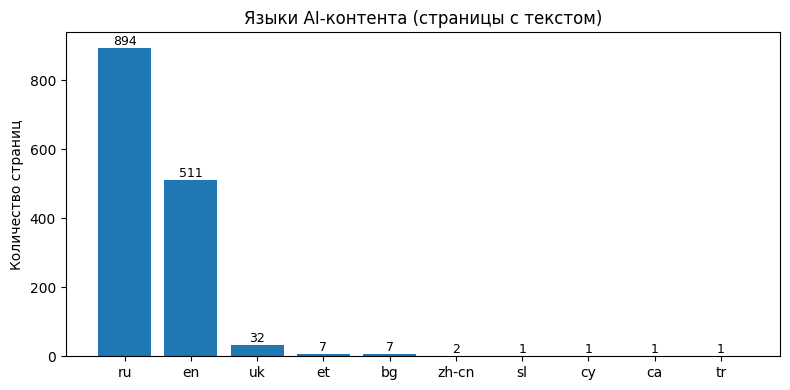

In [6]:
# 1) чистим именно ту колонку, из которой строим график
df_text["language_detected"] = df_text["language_detected"].fillna("unknown")

# если хочешь убрать служебную метку совсем
df_text["language_detected"] = df_text["language_detected"].replace({
    "not_enough_content": "unknown"
})

# 2) для графика исключаем unknown (и всё служебное)
df_lang_plot = df_text[df_text["language_detected"] != "unknown"].copy()

# 3) считаем и строим
lang_counts = df_lang_plot["language_detected"].value_counts()
lang_pct = (lang_counts / lang_counts.sum() * 100).round(1)

lang_table = pd.DataFrame({
    "Язык": lang_counts.index,
    "Страниц (с текстом)": lang_counts.values,
    "Доля (%)": lang_pct.values
})

top_lang = lang_table.head(10)

plt.figure(figsize=(8,4))
plt.bar(top_lang["Язык"], top_lang["Страниц (с текстом)"])
plt.ylabel("Количество страниц")
plt.title("Языки AI-контента (страницы с текстом)")

for x, y in zip(top_lang["Язык"], top_lang["Страниц (с текстом)"]):
    plt.text(x, y + max(top_lang["Страниц (с текстом)"])*0.01, int(y),
             ha="center", fontsize=9)

plt.tight_layout()
plt.show()


**Вывод (языки):**
- Основной массив AI-контента на сайтах вузов представлен на `ru` и `en`.
- Отсутствие/низкая доля `kk` в детекции не означает отсутствия казахского языка: тексты на казахском в кириллице часто распознаются как `ru`.
- Для точной оценки доли казахского языка требуется дополнительная языковая валидация (например, словарные маркеры `ә, ө, ұ, ң, қ, һ, і`).

In [7]:
kazakh_letters = set("әғқңөұүіһӘҒҚҢӨҰҮІҺ")

def contains_kazakh(text):
    if not isinstance(text, str):
        return False
    return any(ch in kazakh_letters for ch in text)


In [8]:
ru_mask = df_text["language_detected"].eq("ru")

kazakh_inside_ru = df_text.loc[ru_mask, "content_text"].apply(contains_kazakh)

kazakh_hidden = int(kazakh_inside_ru.sum())
total_ru = int(ru_mask.sum())
share_hidden = round(kazakh_hidden / total_ru * 100, 2) if total_ru else 0

kazakh_hidden, total_ru, share_hidden


(336, 894, 37.58)

In [9]:
kazakh_inside_ru.value_counts()


content_text
False    558
True     336
Name: count, dtype: int64

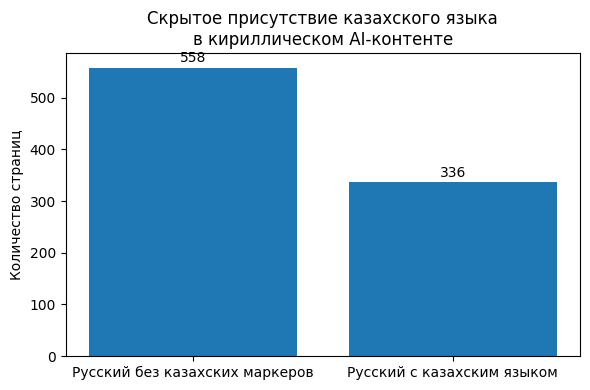

In [10]:
labels = ["Русский без казахских маркеров", "Русский с казахским языком"]
values = [total_ru - kazakh_hidden, kazakh_hidden]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, values)
plt.ylabel("Количество страниц")
plt.title("Скрытое присутствие казахского языка\nв кириллическом AI-контенте")

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + max(values)*0.02, f"{int(h)}", ha="center")

plt.tight_layout()
plt.show()


Дополнительный анализ кириллических текстов, автоматически классифицированных как русскоязычные, выявил наличие казахских языковых маркеров в части материалов. Это подтверждает, что казахский язык присутствует в AI-контенте университетов, однако его цифровая репрезентация может быть не институционализирована в форме чётко размеченных языковых версий, что затрудняет автоматическую идентификацию и последующий анализ.

## 5. Типы контента: числа → проценты → интерпретация

In [11]:

type_counts = df_text["content_type"].value_counts()
type_pct = (type_counts / type_counts.sum() * 100).round(1)

type_table = pd.DataFrame({
    "Тип контента": type_counts.index,
    "Страниц (с текстом)": type_counts.values,
    "Доля (%)": type_pct.values
})
type_table


,Тип контента,Страниц (с текстом),Доля (%)
0,news,486,33.2
1,education,371,25.3
2,other,370,25.3
3,research,226,15.4
4,strategy,11,0.8


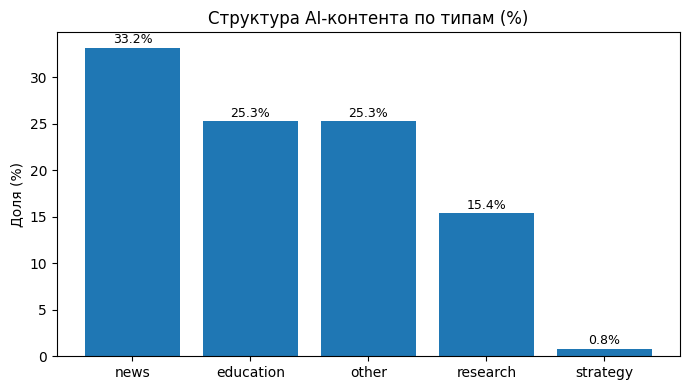

In [12]:

plt.figure(figsize=(7,4))
plt.bar(type_table["Тип контента"], type_table["Доля (%)"])
plt.ylabel("Доля (%)")
plt.title("Структура AI-контента по типам (%)")

for x, y in zip(type_table["Тип контента"], type_table["Доля (%)"]):
    plt.text(x, y + 0.5, f"{y}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


**Интерпретация (типы):**
- `education` отражает AI-контент, связанный с образовательными программами, дисциплинами, поступлением и обучением.
- `research` — исследования, гранты, лаборатории, публикации.
- `news` — новостные сообщения и события.
- `strategy` — стратегии/концепции/дорожные карты.
- `other` — страницы, не попавшие под ключевые паттерны (их можно уточнять правилами).

Структура AI-контента по типам демонстрирует явное доминирование новостных и образовательных материалов. Наибольшую долю составляют новости, на которые приходится около трети всех страниц с текстом, что указывает на преимущественно событийную и репрезентативную модель цифрового присутствия AI-тематики. Существенную часть контента также формируют образовательные материалы, связанные с программами обучения, дисциплинами и академическими курсами, что отражает институциональный акцент университетов на образовательной функции AI.

Исследовательский контент представлен заметно в меньшей степени, что свидетельствует о том, что научная и проектная деятельность в сфере AI не является доминирующим элементом веб-репрезентации. Категория «other» сопоставима по объёму с образовательным контентом, что может указывать на методологические ограничения автоматической классификации и наличие гибридных или плохо формализуемых материалов. Стратегические документы, связанные с долгосрочным развитием AI, представлены минимально, что подчёркивает слабую институционализацию AI-повестки на уровне стратегического планирования, по крайней мере в публичном цифровом пространстве университетов.

## 6. Топ университетов по объему AI-контента (сначала числа, затем проценты)

In [13]:

# Считаем по ядру (>=100 слов) — более “содержательные” страницы
core = df_text[df_text["good_100"] & (~df_text["is_pdf"])].copy()

uni_counts = core["domain_filter"].value_counts()
top20 = uni_counts.head(20).reset_index()
top20.columns = ["Домен", "Страниц (ядро >=100 слов)"]
top20

,Домен,Страниц (ядро >=100 слов)
0,farabi.university,30
1,mnu.kz,26
2,nu.edu.kz,26
3,kaznpu.kz,26
4,satbayev.university,26
5,aiu.kz,25
6,cardiff.ac.uk,24
7,sdu.edu.kz,24
8,enu.kz,24
9,astanait.edu.kz,23


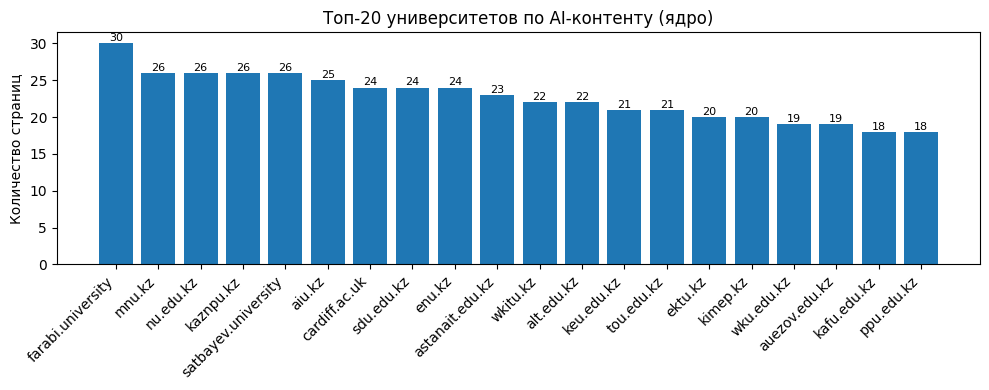

In [14]:

plt.figure(figsize=(10,4))
plt.bar(top20["Домен"], top20["Страниц (ядро >=100 слов)"])
plt.ylabel("Количество страниц")
plt.title("Топ-20 университетов по AI-контенту (ядро)")

plt.xticks(rotation=45, ha="right")

for x, y in zip(top20["Домен"], top20["Страниц (ядро >=100 слов)"]):
    plt.text(x, y + 0.3, int(y), ha="center", fontsize=8)

plt.tight_layout()
plt.show()


In [15]:

# Проценты от общего ядра
top10 = uni_counts.head(10)
top10_pct = (top10 / uni_counts.sum() * 100).round(2)

top10_pct_table = pd.DataFrame({
    "Домен": top10_pct.index,
    "Доля ядра (%)": top10_pct.values
})
top10_pct_table


,Домен,Доля ядра (%)
0,farabi.university,2.56
1,mnu.kz,2.22
2,nu.edu.kz,2.22
3,kaznpu.kz,2.22
4,satbayev.university,2.22
5,aiu.kz,2.13
6,cardiff.ac.uk,2.05
7,sdu.edu.kz,2.05
8,enu.kz,2.05
9,astanait.edu.kz,1.96


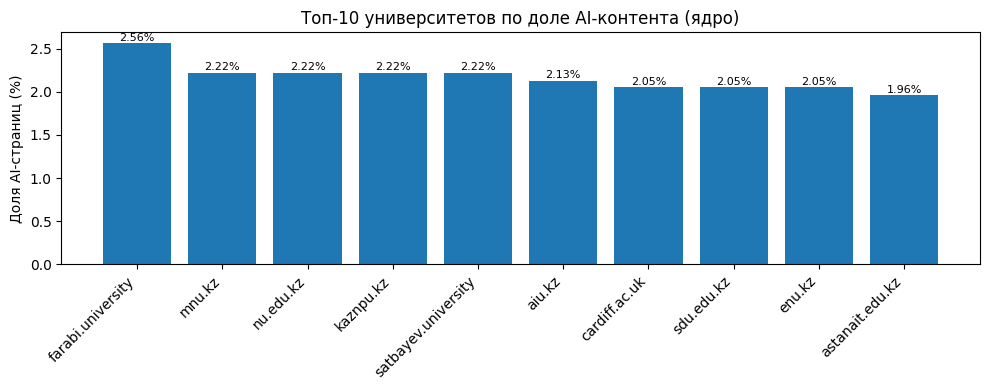

In [16]:

plt.figure(figsize=(10,4))
plt.bar(top10_pct_table["Домен"], top10_pct_table["Доля ядра (%)"])
plt.ylabel("Доля AI-страниц (%)")
plt.title("Топ-10 университетов по доле AI-контента (ядро)")

plt.xticks(rotation=45, ha="right")

for x, y in zip(top10_pct_table["Домен"], top10_pct_table["Доля ядра (%)"]):
    plt.text(x, y + 0.03, f"{y}%", ha="center", fontsize=8)

plt.tight_layout()
plt.show()


### Аналитическая интерпретация распределения университетов по AI-контенту

Сравнительный анализ университетов по объёму AI-ориентированного контента выявляет заметную концентрацию публикаций у ограниченного круга институций. Лидирующие позиции занимают университеты, систематически представленные в цифровом пространстве AI-тематики, что отражает более активную и институционально закрепленную стратегию публичной репрезентации данного направления. Вместе с тем даже у лидеров абсолютное количество AI-страниц остаётся относительно умеренным, что указывает на отсутствие массовой и глубоко структурированной AI-повестки в университетском веб-контенте в целом.

Анализ доли AI-контента в структуре сайтов дополняет этот вывод, демонстрируя, что даже у университетов-лидеров удельный вес AI-страниц не превышает нескольких процентов от общего объема текстового контента. Это свидетельствует о том, что AI, несмотря на его стратегическую значимость, чаще интегрируется в существующие информационные и образовательные блоки, а не формирует самостоятельный и приоритетный сегмент цифровой коммуникации. Таким образом, различия между университетами проявляются скорее в степени символического присутствия AI в публичном дискурсе, чем в масштабах реального контентного доминирования данного направления.

## 7. Динамика (по доступным годам)
**Важно:** графики строятся только для страниц, где удалось извлечь `pub_year`.
Если на некоторых сайтах даты отсутствуют, часть контента в динамику не попадёт.

In [17]:

dyn = df_text[df_text["pub_year"].notna()].copy()
dyn["pub_year"] = dyn["pub_year"].astype(int)

year_counts = dyn.groupby("pub_year").size().sort_index()
year_counts.tail(20)


pub_year
2007      2
2008      7
2009     13
2010      3
2011     11
2012     15
2013      3
2014      5
2015      9
2016      2
2017     10
2018      9
2019     10
2020     17
2021     21
2022     19
2023     46
2024    123
2025    395
2026     35
dtype: int64

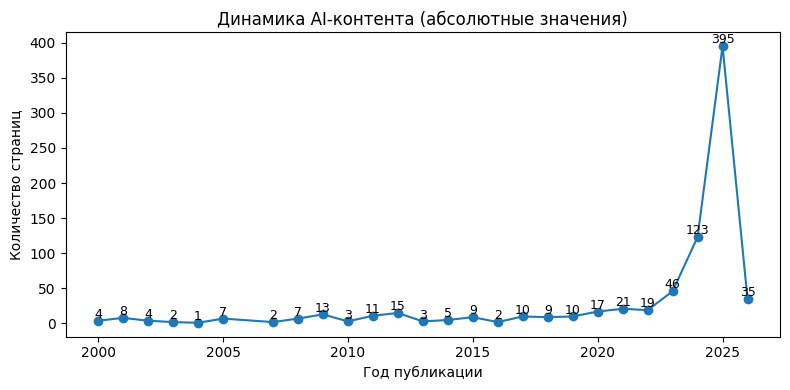

In [18]:

plt.figure(figsize=(8,4))
plt.plot(year_counts.index, year_counts.values, marker="o")
plt.xlabel("Год публикации")
plt.ylabel("Количество страниц")
plt.title("Динамика AI-контента (абсолютные значения)")

for x, y in zip(year_counts.index, year_counts.values):
    plt.text(x, y + max(year_counts.values)*0.01, int(y), ha="center", fontsize=9)

plt.tight_layout()
plt.show()


### Аналитическая интерпретация динамики AI-контента

Динамика AI-ориентированного контента в долгосрочной перспективе демонстрирует чётко выраженный разрыв между ранним и поздним периодами. На протяжении 2000-х и большей части 2010-х годов количество публикаций, связанных с искусственным интеллектом, остаётся крайне низким и фрагментарным, что указывает на эпизодический характер упоминаний AI в университетском цифровом пространстве. В этот период AI не выступает в качестве самостоятельной и институционально закреплённой темы, а появляется преимущественно в контексте отдельных новостей, мероприятий или экспериментальных инициатив.

Ситуация принципиально меняется после 2020 года, когда наблюдается ускоренный рост количества AI-страниц, достигающий пиковых значений в середине 2020-х годов. Резкий скачок в последние годы отражает не только расширение реального объёма AI-деятельности университетов, но и изменение стратегий цифровой коммуникации, в рамках которых AI начинает позиционироваться как приоритетное и символически значимое направление. При этом экстремальное значение пика следует интерпретировать с осторожностью, поскольку оно может быть связано как с институционализацией AI-повестки, так и с эффектами массовой публикации однотипного контента, переразметкой сайтов или особенностями сбора данных.

Резкое снижение показателя в последнем году не обязательно свидетельствует о фактическом спаде интереса к AI, а скорее отражает неполноту данных за текущий период или временной лаг между публикацией материалов и их индексацией. В совокупности динамика указывает на то, что AI как тема университетского контента является феноменом позднего этапа цифровой трансформации высшего образования, характеризующимся быстрым, но пока нестабильным ростом.

### 7.1 Динамика по типам (stacked)
Показывает, какие типы AI-контента доминируют в разные годы (там, где год найден).

In [19]:

year_type = (dyn.groupby(["pub_year","content_type"]).size()
             .unstack(fill_value=0)
             .sort_index())

year_type.tail(20)


content_type,education,news,other,research,strategy
pub_year,,,,,
2007,0,0,1,1,0
2008,2,3,0,2,0
2009,4,5,3,1,0
2010,2,0,0,1,0
2011,4,2,1,4,0
2012,7,3,3,2,0
2013,3,0,0,0,0
2014,1,1,2,1,0
2015,0,0,9,0,0


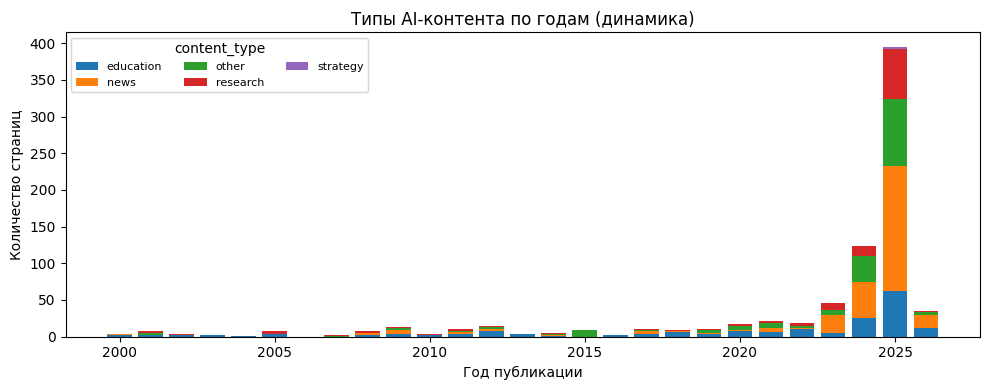

In [20]:

plt.figure(figsize=(10,4))
bottom = np.zeros(len(year_type))

for col in year_type.columns:
    vals = year_type[col].values
    plt.bar(year_type.index, vals, bottom=bottom, label=col)
    bottom += vals

plt.xlabel("Год публикации")
plt.ylabel("Количество страниц")
plt.title("Типы AI-контента по годам (динамика)")
plt.legend(title="content_type", ncol=3, fontsize=8)
plt.tight_layout()
plt.show()


### Аналитическая интерпретация динамики типов AI-контента по годам

Распределение типов AI-контента в динамике позволяет уточнить характер роста, зафиксированного на уровне агрегированных показателей. В ранний период, охватывающий 2000-е и значительную часть 2010-х годов, AI-ориентированные публикации представлены фрагментарно и не демонстрируют устойчивой структуры по типам. Отдельные материалы носят преимущественно новостной или разрозненный характер, что указывает на отсутствие системной контентной политики в отношении искусственного интеллекта.

Начиная с конца 2010-х годов наблюдается постепенная дифференциация типов AI-контента, однако ключевые изменения происходят в первой половине 2020-х годов. Резкий рост общего объёма AI-публикаций сопровождается доминированием новостного контента, что свидетельствует о реактивной модели цифровой коммуникации, ориентированной на освещение мероприятий, заявлений и краткосрочных инициатив. Одновременно увеличивается доля материалов, отнесённых к категории «other», что может отражать как расширение тематического спектра AI, так и ограничения автоматической классификации при росте объёма разнородных текстов.

Исследовательский и образовательный контент также демонстрируют рост, однако их вклад в общую динамику остаётся сравнительно умеренным. Это указывает на то, что институционализация AI в университетском цифровом пространстве происходит преимущественно на уровне публичного дискурса и символического позиционирования, тогда как систематическая репрезентация исследовательской деятельности и образовательных программ развивается более медленно. Стратегические материалы, связанные с долгосрочным развитием AI, остаются маргинальными на протяжении всего периода наблюдения, что подчёркивает разрыв между риторическим усилением AI-повестки и её формальным закреплением в стратегических документах.

В совокупности анализ подтверждает, что рост AI-контента носит не только количественный, но и структурно асимметричный характер, при котором расширение информационного и событийного контента опережает развитие аналитических, образовательных и стратегических форм репрезентации искусственного интеллекта.

## 8. Профили университетов (education / research / strategy / mixed)
Профиль определяется по доминирующему типу AI-контента среди страниц ядра (>=100 слов).

In [21]:

# Агрегация по доменам по ядру
pivot_uni = (core.groupby(["domain_filter","content_type"]).size()
             .unstack(fill_value=0))

pivot_uni["total"] = pivot_uni.sum(axis=1)

# добавим недостающие колонки, если их нет
for c in ["education","research","news","strategy","other"]:
    if c not in pivot_uni.columns:
        pivot_uni[c] = 0

def classify_university(row):
    total = row["total"]
    if total == 0:
        return "mixed / low-activity"
    shares = {k: row[k]/total for k in ["education","research","strategy","news","other"]}
    # простая логика профиля
    if shares["education"] >= 0.45:
        return "education-oriented"
    if shares["research"] >= 0.45:
        return "research-oriented"
    if shares["strategy"] >= 0.20:
        return "strategy-driven"
    return "mixed / low-activity"

pivot_uni["profile"] = pivot_uni.apply(classify_university, axis=1)

# Top-15 по total
pivot_uni_sorted = pivot_uni.sort_values("total", ascending=False)
pivot_uni_sorted[["education","research","news","strategy","other","total","profile"]].head(15)


content_type,education,research,news,strategy,other,total,profile
domain_filter,,,,,,,
farabi.university,3,0,27,0,0,30,mixed / low-activity
nu.edu.kz,5,11,6,0,4,26,mixed / low-activity
satbayev.university,9,6,10,0,1,26,mixed / low-activity
mnu.kz,5,8,12,0,1,26,mixed / low-activity
kaznpu.kz,4,4,13,0,5,26,mixed / low-activity
aiu.kz,1,4,18,0,2,25,mixed / low-activity
cardiff.ac.uk,12,6,2,1,3,24,education-oriented
enu.kz,5,13,2,1,3,24,research-oriented
sdu.edu.kz,7,9,7,0,1,24,mixed / low-activity


### 8.1 Распределение профилей (в процентах)

In [22]:

profile_counts = pivot_uni["profile"].value_counts()
profile_pct = (profile_counts / profile_counts.sum() * 100).round(1)

profile_table = pd.DataFrame({
    "Профиль": profile_counts.index,
    "Университетов": profile_counts.values,
    "Доля (%)": profile_pct.values
})
profile_table


,Профиль,Университетов,Доля (%)
0,mixed / low-activity,77,73.3
1,education-oriented,21,20.0
2,research-oriented,6,5.7
3,strategy-driven,1,1.0


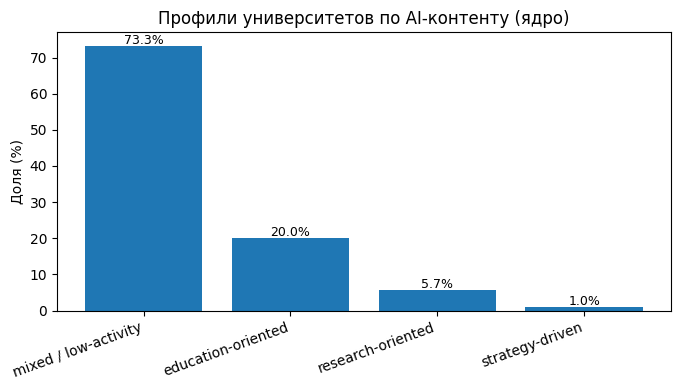

In [23]:

plt.figure(figsize=(7,4))
plt.bar(profile_table["Профиль"], profile_table["Доля (%)"])
plt.ylabel("Доля (%)")
plt.title("Профили университетов по AI-контенту (ядро)")

plt.xticks(rotation=20, ha="right")

for x, y in zip(profile_table["Профиль"], profile_table["Доля (%)"]):
    plt.text(x, y + 0.5, f"{y}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


### Аналитическая интерпретация профилей университетов по AI-контенту

Построенная типология университетов по профилям AI-контента выявляет высокую степень асимметрии в стратегиях цифровой репрезентации искусственного интеллекта. Абсолютное большинство университетов относится к категории смешанного или низкоактивного профиля, что указывает на фрагментарное и нерегулярное присутствие AI-тематики на официальных веб-ресурсах. В рамках данного профиля AI, как правило, не выступает в качестве приоритетного направления, а интегрируется в общий информационный поток без чёткой структурной или институциональной фиксации.

Образовательный профиль, представленный примерно пятой частью университетов, отражает более целенаправленное использование AI в контексте учебных программ, курсов и образовательных инициатив. Однако даже в этой группе AI чаще выполняет функцию тематического расширения образовательной повестки, нежели становится основой для системной исследовательской или стратегической специализации. Исследовательски ориентированный профиль встречается значительно реже, что свидетельствует о слабой публичной репрезентации научной деятельности в сфере AI, несмотря на возможное наличие реальных исследовательских проектов и лабораторий.

Стратегически ориентированный профиль является маргинальным и представлен единичными случаями, что указывает на отсутствие широкого институционального закрепления AI в долгосрочных стратегических документах университетов. В совокупности полученная структура профилей демонстрирует, что AI в университетском цифровом пространстве в настоящее время выступает преимущественно как элемент символического позиционирования и образовательной коммуникации, тогда как его роль как системного исследовательского и стратегического приоритета остаётся ограниченной.

## 9. Итоговые выводы


1. AI-контент присутствует на сайтах значительного числа университетов (по доменам), но распределён неравномерно: часть вузов формирует «ядро» публикаций.
2. Языковая структура доминирует в пользу `ru` и `en`; казахский язык в кириллице может быть частично учтён внутри `ru`.
3. По типам контента чаще всего доминируют материалы, связанные с образованием (`education`) и исследованиями (`research`), в то время как стратегические документы (`strategy`) встречаются реже.
4. Динамика по годам зависит от доступности дат в контенте/URL/метаданных; где год извлечён, обычно виден рост публикаций в последние годы.
5. Профили университетов показывают разную институциональную «ориентацию» AI-повестки: образовательную, исследовательскую, стратегическую или смешанную.


## 10. Рекомендации


- Усилить присутствие AI-контента на казахском языке и улучшить его техническую маркировку (метаданные/разметка), чтобы он корректно распознавался автоматическими детекторами.
- Для повышения прозрачности рекомендовано стандартизировать разделы: «AI-образование», «AI-исследования», «AI-проекты/гранты», «Стратегия цифрового развития».
- Для стратегической зрелости вузов — публиковать дорожные карты, KPI, результаты внедрения (планы/отчёты), а не только новости и объявления.
- Для исследовательского направления — централизовать публикации проектов/лабораторий и связывать их с образовательными треками.


## 11. Ограничения и future research


**Ограничения:**
- Автоматическая детекция языка не всегда корректно выделяет казахский язык, особенно при кириллическом письме.
- Не у всех страниц доступны даты публикации, поэтому динамика отражает только подвыборку.
- Классификация типов основана на правилах/паттернах; возможны ошибки на отдельных сайтах.

**Future research:**
- Улучшенная детекция казахского языка (словарные маркеры, модели lang-id).
- Более точное извлечение даты (HTML-метатеги, schema.org, OpenGraph).
- Тематическое моделирование (topic modeling) и сравнение вузов по темам AI-контента.


## 12. Экспорт результатов (CSV/Excel) и сохранение графиков

In [24]:

from pathlib import Path

OUT_DIR = Path("output")
FIG_DIR = OUT_DIR / "figures"
OUT_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Сохраним очищенную таблицу
df.to_csv(OUT_DIR / "ai_pages_full.csv", index=False, encoding="utf-8-sig")
df_text.to_csv(OUT_DIR / "ai_pages_text_only.csv", index=False, encoding="utf-8-sig")

# Университетские профили
pivot_uni_sorted.to_csv(OUT_DIR / "university_profiles_core.csv", encoding="utf-8-sig")

print("✅ Сохранено в папку:", OUT_DIR.resolve())


✅ Сохранено в папку: C:\Users\cheen\Desktop\book_parse\output
